# MAC0417/5768 - Visão e Processamento de Imagens (2021)

Exercício Programa 3.1 - Segmentação de imagens

Gabriela Melo e Richard Block

Projeto GitHub: https://github.com/gabi-melo/image_processing/tree/main/EP3

Base de imagens: https://www.kaggle.com/gabrielamelo/image-processing


# Resumo

Na primeira parte do EP realizamos a segmentação das imagens em níveis de cinza do dataset gerado no EP2. Duas formas de segmentação foram aplicadas: manual e automática. 

Para a segmentação manual, utilizamos cerca de 15% das imagens em níveis de cinza de cada classe de objetos. Foi empregado o programa Label Studio para a segmentação semântica com máscaras. A segmentação manual gerou imagens binárias, em que o valor de 0 corresponde ao fundo e o valor de 1 corresponde ao objeto, compondo o "ground truth" do dataset. Essas imagens binárias foram processadas utilizando um Feret Box para delimitar a área de interesse, fazendo com que a região a ser analisada na etapa de classificação (EP3.2) esteja restrita ao objeto, auxiliando a localização do objeto pelo algoritmo classificador.

Para a segmentação automática usamos um método chamado U square Net, baseado numa arquitetura de rede profunda (disponível em https://arxiv.org/pdf/2005.09007.pdf). Métricas para a avaliação do modelo de segmentação foram computadas.



# Download do Kaggle dataset

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/My Drive/Kaggle
!kaggle datasets download -d gabrielamelo/image-processing

/content/gdrive/My Drive/Kaggle


In [ ]:
# unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

In [4]:
ls '/content/gdrive/My Drive/Kaggle/'

ground_truth/  kaggle.json  objects/  path/


# Segmentação manual

A segmentação manual foi realizada no programa Label Studio. As imagens binárias resultantes compõem o ground truth e estão salvas no dataset do Kaggle.

In [10]:
from glob import glob 

# acessar o conteúdo do diretório das imagens ground truth
for path in glob('/content/gdrive/My Drive/Kaggle/ground_truth/ground_truth/*.png'):
    print(path)

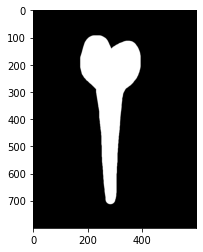

In [9]:
# exemplo de imagem ground truth

ex_segm_manual = '/content/gdrive/My Drive/Kaggle/ground_truth/tesoura_38.png'
ex_img = cv2.imread(ex_segm_manual, 0)
plt.imshow(ex_img, cmap=plt.get_cmap('gray'))

# Segmentação automática

Separamos a tarefa de segmentação automática em duas partes:
1. Criação das máscaras dos objetos, a segmentação de fato.
2. O Feret Box / Blob da região dos objetos, e a padronização destes para a tarefa de classificação.

## 1.

Fizemos uso de uma rede neural treinada, e usamos nossas imagens como testes da rede.

In [ ]:
# download do modelo pré-treinado
!wget -O u2netp.pth https://drive.google.com/u/0/uc?id=1rbSTGKAE-MTxBYHd-51l2hMOQPT_7EPy&export=download 
!wget -O u2netp.onnx https://drive.google.com/uc?id=1OPfir1PXZAABPEZpIppauGKDu8LYXoIm&authuser=0&export=download

In [ ]:
#u2netp
import torch
import torch.nn as nn
from torchvision import models
#import torch.nn.functional as F

### Configurações da rede

In [ ]:
class REBNCONV(nn.Module):
    def __init__(self,in_ch=3,out_ch=3,dirate=1):
        super(REBNCONV,self).__init__()

        self.conv_s1 = nn.Conv2d(in_ch,out_ch,3,padding=1*dirate,dilation=1*dirate)
        self.bn_s1 = nn.BatchNorm2d(out_ch)
        self.relu_s1 = nn.ReLU(inplace=True)

    def forward(self,x):

        hx = x
        xout = self.relu_s1(self.bn_s1(self.conv_s1(hx)))

        return xout

### RSU-7 ###
class RSU7(nn.Module):#UNet07DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU7,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool4 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool5 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv6 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv7 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv6d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv5d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

#        self.upscore2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
# edit for onnx compatibility
        self.upscore2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

    def forward(self,x):

        hx = x
        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)
        hx = self.pool4(hx4)

        hx5 = self.rebnconv5(hx)
        hx = self.pool5(hx5)

        hx6 = self.rebnconv6(hx)

        hx7 = self.rebnconv7(hx6)

        hx6d =  self.rebnconv6d(torch.cat((hx7,hx6),1))
        hx6up = self.upscore2(hx6d)
        # print(hx6up.shape,hx5.shape)
        hx5d =  self.rebnconv5d(torch.cat((hx6up,hx5),1))
        hx5dup = self.upscore2(hx5d)

        hx4d = self.rebnconv4d(torch.cat((hx5dup,hx4),1))
        hx4dup = self.upscore2(hx4d)

        hx3d = self.rebnconv3d(torch.cat((hx4dup,hx3),1))
        hx3dup = self.upscore2(hx3d)

        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = self.upscore2(hx2d)

        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))

        return hx1d + hxin

### RSU-6 ###
class RSU6(nn.Module):#UNet06DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU6,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool4 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv6 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv5d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

        self.upscore2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self,x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)
        hx = self.pool4(hx4)

        hx5 = self.rebnconv5(hx)

        hx6 = self.rebnconv6(hx5)


        hx5d =  self.rebnconv5d(torch.cat((hx6,hx5),1))
        hx5dup = self.upscore2(hx5d)

        hx4d = self.rebnconv4d(torch.cat((hx5dup,hx4),1))
        hx4dup = self.upscore2(hx4d)

        hx3d = self.rebnconv3d(torch.cat((hx4dup,hx3),1))
        hx3dup = self.upscore2(hx3d)

        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = self.upscore2(hx2d)

        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))

        return hx1d + hxin

### RSU-5 ###
class RSU5(nn.Module):#UNet05DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU5,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

        self.upscore2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self,x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)

        hx5 = self.rebnconv5(hx4)

        hx4d = self.rebnconv4d(torch.cat((hx5,hx4),1))
        hx4dup = self.upscore2(hx4d)

        hx3d = self.rebnconv3d(torch.cat((hx4dup,hx3),1))
        hx3dup = self.upscore2(hx3d)

        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = self.upscore2(hx2d)

        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))

        return hx1d + hxin

### RSU-4 ###
class RSU4(nn.Module):#UNet04DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

        self.upscore2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self,x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)

        hx4 = self.rebnconv4(hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4,hx3),1))
        hx3dup = self.upscore2(hx3d)

        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = self.upscore2(hx2d)

        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))

        return hx1d + hxin

### RSU-4F ###
class RSU4F(nn.Module):#UNet04FRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4F,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=2)
        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=4)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=8)

        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=4)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=2)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx2 = self.rebnconv2(hx1)
        hx3 = self.rebnconv3(hx2)

        hx4 = self.rebnconv4(hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4,hx3),1))
        hx2d = self.rebnconv2d(torch.cat((hx3d,hx2),1))
        hx1d = self.rebnconv1d(torch.cat((hx2d,hx1),1))

        return hx1d + hxin


##### U^2-Net ####
class U2NET(nn.Module):

    def __init__(self,in_ch=3,out_ch=1):
        super(U2NET,self).__init__()

        self.stage1 = RSU7(in_ch,32,64)
        self.pool12 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage2 = RSU6(64,32,128)
        self.pool23 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage3 = RSU5(128,64,256)
        self.pool34 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage4 = RSU4(256,128,512)
        self.pool45 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage5 = RSU4F(512,256,512)
        self.pool56 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage6 = RSU4F(512,256,512)

        # decoder
        self.stage5d = RSU4F(1024,256,512)
        self.stage4d = RSU4(1024,128,256)
        self.stage3d = RSU5(512,64,128)
        self.stage2d = RSU6(256,32,64)
        self.stage1d = RSU7(128,16,64)

        self.side1 = nn.Conv2d(64,1,3,padding=1)
        self.side2 = nn.Conv2d(64,1,3,padding=1)
        self.side3 = nn.Conv2d(128,1,3,padding=1)
        self.side4 = nn.Conv2d(256,1,3,padding=1)
        self.side5 = nn.Conv2d(512,1,3,padding=1)
        self.side6 = nn.Conv2d(512,1,3,padding=1)

        self.upscore6 = nn.Upsample(scale_factor=32,mode='bilinear',align_corners=True)
        self.upscore5 = nn.Upsample(scale_factor=16,mode='bilinear',align_corners=True)
        self.upscore4 = nn.Upsample(scale_factor=8,mode='bilinear',align_corners=True)
        self.upscore3 = nn.Upsample(scale_factor=4,mode='bilinear',align_corners=True)
        self.upscore2 = nn.Upsample(scale_factor=2, mode='bilinear',align_corners=True)

        self.outconv = nn.Conv2d(6,1,1)

    def forward(self,x):

        hx = x

        #stage 1
        hx1 = self.stage1(hx)
        hx = self.pool12(hx1)

        #stage 2
        hx2 = self.stage2(hx)
        hx = self.pool23(hx2)



        #stage 3
        hx3 = self.stage3(hx)
        hx = self.pool34(hx3)

        #stage 4
        hx4 = self.stage4(hx)
        hx = self.pool45(hx4)

        #stage 5
        hx5 = self.stage5(hx)
        hx = self.pool56(hx5)

        #stage 6
        hx6 = self.stage6(hx)
        hx6up = self.upscore2(hx6)

        #-------------------- decoder --------------------
        hx5d = self.stage5d(torch.cat((hx6up,hx5),1))
        hx5dup = self.upscore2(hx5d)

        hx4d = self.stage4d(torch.cat((hx5dup,hx4),1))
        hx4dup = self.upscore2(hx4d)

        hx3d = self.stage3d(torch.cat((hx4dup,hx3),1))
        hx3dup = self.upscore2(hx3d)

        hx2d = self.stage2d(torch.cat((hx3dup,hx2),1))
        hx2dup = self.upscore2(hx2d)

        hx1d = self.stage1d(torch.cat((hx2dup,hx1),1))


        #side output
        d1 = self.side1(hx1d)

        d2 = self.side2(hx2d)
        d2 = self.upscore2(d2)

        d3 = self.side3(hx3d)
        d3 = self.upscore3(d3)

        d4 = self.side4(hx4d)
        d4 = self.upscore4(d4)

        d5 = self.side5(hx5d)
        d5 = self.upscore5(d5)

        d6 = self.side6(hx6)
        d6 = self.upscore6(d6)

        d0 = self.outconv(torch.cat((d1,d2,d3,d4,d5,d6),1))

        F.sigmokd
        return torch.sigmoid(d0), torch.sigmoid(d1), torch.sigmoid(d2), torch.sigmoid(d3), torch.sigmoid(d4), torch.sigmoid(d5), torch.sigmoid(d6)

### U^2-Net small ###
class U2NETP(nn.Module):

    def __init__(self,in_ch=3,out_ch=1):
        super(U2NETP,self).__init__()

        self.stage1 = RSU7(in_ch,16,64)
        self.pool12 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage2 = RSU6(64,16,64)
        self.pool23 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage3 = RSU5(64,16,64)
        self.pool34 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage4 = RSU4(64,16,64)
        self.pool45 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage5 = RSU4F(64,16,64)
        self.pool56 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage6 = RSU4F(64,16,64)

        # decoder
        self.stage5d = RSU4F(128,16,64)
        self.stage4d = RSU4(128,16,64)
        self.stage3d = RSU5(128,16,64)
        self.stage2d = RSU6(128,16,64)
        self.stage1d = RSU7(128,16,64)

        self.side1 = nn.Conv2d(64,1,3,padding=1)
        self.side2 = nn.Conv2d(64,1,3,padding=1)
        self.side3 = nn.Conv2d(64,1,3,padding=1)
        self.side4 = nn.Conv2d(64,1,3,padding=1)
        self.side5 = nn.Conv2d(64,1,3,padding=1)
        self.side6 = nn.Conv2d(64,1,3,padding=1)

        self.upscore6 = nn.Upsample(scale_factor=32,mode='bilinear',align_corners=True)
        self.upscore5 = nn.Upsample(scale_factor=16,mode='bilinear',align_corners=True)
        self.upscore4 = nn.Upsample(scale_factor=8,mode='bilinear',align_corners=True)
        self.upscore3 = nn.Upsample(scale_factor=4,mode='bilinear',align_corners=True)
        self.upscore2 = nn.Upsample(scale_factor=2, mode='bilinear',align_corners=True)

        self.outconv = nn.Conv2d(6,1,1)

    def forward(self,x):

        hx = x

        #stage 1
        hx1 = self.stage1(hx)
        hx = self.pool12(hx1)

        #stage 2
        hx2 = self.stage2(hx)
        hx = self.pool23(hx2)

        #stage 3
        hx3 = self.stage3(hx)
        hx = self.pool34(hx3)

        #stage 4
        hx4 = self.stage4(hx)
        hx = self.pool45(hx4)

        #stage 5
        hx5 = self.stage5(hx)
        hx = self.pool56(hx5)

        #stage 6
        hx6 = self.stage6(hx)
        hx6up = self.upscore2(hx6)

        #decoder
        hx5d = self.stage5d(torch.cat((hx6up,hx5),1))
        hx5dup = self.upscore2(hx5d)

        hx4d = self.stage4d(torch.cat((hx5dup,hx4),1))
        hx4dup = self.upscore2(hx4d)

        hx3d = self.stage3d(torch.cat((hx4dup,hx3),1))
        hx3dup = self.upscore2(hx3d)

        hx2d = self.stage2d(torch.cat((hx3dup,hx2),1))
        hx2dup = self.upscore2(hx2d)

        hx1d = self.stage1d(torch.cat((hx2dup,hx1),1))


        #side output
        d1 = self.side1(hx1d)

        d2 = self.side2(hx2d)
        d2 = self.upscore2(d2)

        d3 = self.side3(hx3d)
        d3 = self.upscore3(d3)

        d4 = self.side4(hx4d)
        d4 = self.upscore4(d4)

        d5 = self.side5(hx5d)
        d5 = self.upscore5(d5)

        d6 = self.side6(hx6)
        d6 = self.upscore6(d6)

        d0 = self.outconv(torch.cat((d1,d2,d3,d4,d5,d6),1))
        # d00 = d0 + self.refconv(d0)

        return torch.sigmoid(d0), torch.sigmoid(d1), torch.sigmoid(d2), torch.sigmoid(d3), torch.sigmoid(d4), torch.sigmoid(d5), torch.sigmoid(d6)

In [ ]:
net = U2NETP(3,1)

### Data loader e transformaçções das imagens para serem usadas na rede neural

In [ ]:
# data loader
from __future__ import print_function, division
import glob
import torch
from skimage import io, transform, color
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
#==========================dataset load==========================
class RescaleT(object):

	def __init__(self,output_size):
		assert isinstance(output_size,(int,tuple))
		self.output_size = output_size

	def __call__(self,sample):
		imidx, image, label = sample['imidx'], sample['image'],sample['label']

		h, w = image.shape[:2]

		if isinstance(self.output_size,int):
			if h > w:
				new_h, new_w = self.output_size*h/w,self.output_size
			else:
				new_h, new_w = self.output_size,self.output_size*w/h
		else:
			new_h, new_w = self.output_size

		new_h, new_w = int(new_h), int(new_w)

		# #resize the image to new_h x new_w and convert image from range [0,255] to [0,1]
		# img = transform.resize(image,(new_h,new_w),mode='constant')
		# lbl = transform.resize(label,(new_h,new_w),mode='constant', order=0, preserve_range=True)

		img = transform.resize(image,(self.output_size,self.output_size),mode='constant')
		lbl = transform.resize(label,(self.output_size,self.output_size),mode='constant', order=0, preserve_range=True)

		return {'imidx':imidx, 'image':img,'label':lbl}

class Rescale(object):

	def __init__(self,output_size):
		assert isinstance(output_size,(int,tuple))
		self.output_size = output_size

	def __call__(self,sample):
		imidx, image, label = sample['imidx'], sample['image'],sample['label']

		h, w = image.shape[:2]

		if isinstance(self.output_size,int):
			if h > w:
				new_h, new_w = self.output_size*h/w,self.output_size
			else:
				new_h, new_w = self.output_size,self.output_size*w/h
		else:
			new_h, new_w = self.output_size

		new_h, new_w = int(new_h), int(new_w)

		# #resize the image to new_h x new_w and convert image from range [0,255] to [0,1]
		img = transform.resize(image,(new_h,new_w),mode='constant')
		lbl = transform.resize(label,(new_h,new_w),mode='constant', order=0, preserve_range=True)

		return {'imidx':imidx, 'image':img,'label':lbl}

class RandomCrop(object):

	def __init__(self,output_size):
		assert isinstance(output_size, (int, tuple))
		if isinstance(output_size, int):
			self.output_size = (output_size, output_size)
		else:
			assert len(output_size) == 2
			self.output_size = output_size
	def __call__(self,sample):
		imidx, image, label = sample['imidx'], sample['image'], sample['label']

		h, w = image.shape[:2]
		new_h, new_w = self.output_size

		top = np.random.randint(0, h - new_h)
		left = np.random.randint(0, w - new_w)

		image = image[top: top + new_h, left: left + new_w]
		label = label[top: top + new_h, left: left + new_w]

		return {'imidx':imidx,'image':image, 'label':label}

class ToTensor(object):
	"""Convert ndarrays in sample to Tensors."""

	def __call__(self, sample):

		imidx, image, label = sample['imidx'], sample['image'], sample['label']

		tmpImg = np.zeros((image.shape[0],image.shape[1],3))
		tmpLbl = np.zeros(label.shape)

		image = image/np.max(image)
		if(np.max(label)<1e-6):
			label = label
		else:
			label = label/np.max(label)

		if image.shape[2]==1:
			tmpImg[:,:,0] = (image[:,:,0]-0.485)/0.229
			tmpImg[:,:,1] = (image[:,:,0]-0.485)/0.229
			tmpImg[:,:,2] = (image[:,:,0]-0.485)/0.229
		else:
			tmpImg[:,:,0] = (image[:,:,0]-0.485)/0.229
			tmpImg[:,:,1] = (image[:,:,1]-0.456)/0.224
			tmpImg[:,:,2] = (image[:,:,2]-0.406)/0.225

		tmpLbl[:,:,0] = label[:,:,0]

		# change the r,g,b to b,r,g from [0,255] to [0,1]
		#transforms.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))
		tmpImg = tmpImg.transpose((2, 0, 1))
		tmpLbl = label.transpose((2, 0, 1))

		return {'imidx':torch.from_numpy(imidx), 'image': torch.from_numpy(tmpImg), 'label': torch.from_numpy(tmpLbl)}

class ToTensorLab(object):
	"""Convert ndarrays in sample to Tensors."""
	def __init__(self,flag=0):
		self.flag = flag

	def __call__(self, sample):

		imidx, image, label =sample['imidx'], sample['image'], sample['label']

		tmpLbl = np.zeros(label.shape)

		if(np.max(label)<1e-6):
			label = label
		else:
			label = label/np.max(label)

		# change the color space
		if self.flag == 2: # with rgb and Lab colors
			tmpImg = np.zeros((image.shape[0],image.shape[1],6))
			tmpImgt = np.zeros((image.shape[0],image.shape[1],3))
			if image.shape[2]==1:
				tmpImgt[:,:,0] = image[:,:,0]
				tmpImgt[:,:,1] = image[:,:,0]
				tmpImgt[:,:,2] = image[:,:,0]
			else:
				tmpImgt = image
			tmpImgtl = color.rgb2lab(tmpImgt)

			# nomalize image to range [0,1]
			tmpImg[:,:,0] = (tmpImgt[:,:,0]-np.min(tmpImgt[:,:,0]))/(np.max(tmpImgt[:,:,0])-np.min(tmpImgt[:,:,0]))
			tmpImg[:,:,1] = (tmpImgt[:,:,1]-np.min(tmpImgt[:,:,1]))/(np.max(tmpImgt[:,:,1])-np.min(tmpImgt[:,:,1]))
			tmpImg[:,:,2] = (tmpImgt[:,:,2]-np.min(tmpImgt[:,:,2]))/(np.max(tmpImgt[:,:,2])-np.min(tmpImgt[:,:,2]))
			tmpImg[:,:,3] = (tmpImgtl[:,:,0]-np.min(tmpImgtl[:,:,0]))/(np.max(tmpImgtl[:,:,0])-np.min(tmpImgtl[:,:,0]))
			tmpImg[:,:,4] = (tmpImgtl[:,:,1]-np.min(tmpImgtl[:,:,1]))/(np.max(tmpImgtl[:,:,1])-np.min(tmpImgtl[:,:,1]))
			tmpImg[:,:,5] = (tmpImgtl[:,:,2]-np.min(tmpImgtl[:,:,2]))/(np.max(tmpImgtl[:,:,2])-np.min(tmpImgtl[:,:,2]))

			# tmpImg = tmpImg/(np.max(tmpImg)-np.min(tmpImg))

			tmpImg[:,:,0] = (tmpImg[:,:,0]-np.mean(tmpImg[:,:,0]))/np.std(tmpImg[:,:,0])
			tmpImg[:,:,1] = (tmpImg[:,:,1]-np.mean(tmpImg[:,:,1]))/np.std(tmpImg[:,:,1])
			tmpImg[:,:,2] = (tmpImg[:,:,2]-np.mean(tmpImg[:,:,2]))/np.std(tmpImg[:,:,2])
			tmpImg[:,:,3] = (tmpImg[:,:,3]-np.mean(tmpImg[:,:,3]))/np.std(tmpImg[:,:,3])
			tmpImg[:,:,4] = (tmpImg[:,:,4]-np.mean(tmpImg[:,:,4]))/np.std(tmpImg[:,:,4])
			tmpImg[:,:,5] = (tmpImg[:,:,5]-np.mean(tmpImg[:,:,5]))/np.std(tmpImg[:,:,5])

		elif self.flag == 1: #with Lab color
			tmpImg = np.zeros((image.shape[0],image.shape[1],3))

			if image.shape[2]==1:
				tmpImg[:,:,0] = image[:,:,0]
				tmpImg[:,:,1] = image[:,:,0]
				tmpImg[:,:,2] = image[:,:,0]
			else:
				tmpImg = image

			tmpImg = color.rgb2lab(tmpImg)

			# tmpImg = tmpImg/(np.max(tmpImg)-np.min(tmpImg))

			tmpImg[:,:,0] = (tmpImg[:,:,0]-np.min(tmpImg[:,:,0]))/(np.max(tmpImg[:,:,0])-np.min(tmpImg[:,:,0]))
			tmpImg[:,:,1] = (tmpImg[:,:,1]-np.min(tmpImg[:,:,1]))/(np.max(tmpImg[:,:,1])-np.min(tmpImg[:,:,1]))
			tmpImg[:,:,2] = (tmpImg[:,:,2]-np.min(tmpImg[:,:,2]))/(np.max(tmpImg[:,:,2])-np.min(tmpImg[:,:,2]))

			tmpImg[:,:,0] = (tmpImg[:,:,0]-np.mean(tmpImg[:,:,0]))/np.std(tmpImg[:,:,0])
			tmpImg[:,:,1] = (tmpImg[:,:,1]-np.mean(tmpImg[:,:,1]))/np.std(tmpImg[:,:,1])
			tmpImg[:,:,2] = (tmpImg[:,:,2]-np.mean(tmpImg[:,:,2]))/np.std(tmpImg[:,:,2])

		else: # with rgb color
			tmpImg = np.zeros((image.shape[0],image.shape[1],3))
			image = image/np.max(image)
			if image.shape[2]==1:
				tmpImg[:,:,0] = (image[:,:,0]-0.485)/0.229
				tmpImg[:,:,1] = (image[:,:,0]-0.485)/0.229
				tmpImg[:,:,2] = (image[:,:,0]-0.485)/0.229
			else:
				tmpImg[:,:,0] = (image[:,:,0]-0.485)/0.229
				tmpImg[:,:,1] = (image[:,:,1]-0.456)/0.224
				tmpImg[:,:,2] = (image[:,:,2]-0.406)/0.225

		tmpLbl[:,:,0] = label[:,:,0]

		# change the r,g,b to b,r,g from [0,255] to [0,1]
		#transforms.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))
		tmpImg = tmpImg.transpose((2, 0, 1))
		tmpLbl = label.transpose((2, 0, 1))

		return {'imidx':torch.from_numpy(imidx), 'image': torch.from_numpy(tmpImg), 'label': torch.from_numpy(tmpLbl)}

class SalObjDataset(Dataset):
	def __init__(self,img_name_list,lbl_name_list,transform=None):
		# self.root_dir = root_dir
		# self.image_name_list = glob.glob(image_dir+'*.png')
		# self.label_name_list = glob.glob(label_dir+'*.png')
		self.image_name_list = img_name_list
		self.label_name_list = lbl_name_list
		self.transform = transform

	def __len__(self):
		return len(self.image_name_list)

	def __getitem__(self,idx):

		# image = Image.open(self.image_name_list[idx])#io.imread(self.image_name_list[idx])
		# label = Image.open(self.label_name_list[idx])#io.imread(self.label_name_list[idx])

		image = io.imread(self.image_name_list[idx])
		imname = self.image_name_list[idx]
		imidx = np.array([idx])

		if(0==len(self.label_name_list)):
			label_3 = np.zeros(image.shape)
		else:
			label_3 = io.imread(self.label_name_list[idx])

		label = np.zeros(label_3.shape[0:2])
		if(3==len(label_3.shape)):
			label = label_3[:,:,0]
		elif(2==len(label_3.shape)):
			label = label_3

		if(3==len(image.shape) and 2==len(label.shape)):
			label = label[:,:,np.newaxis]
		elif(2==len(image.shape) and 2==len(label.shape)):
			image = image[:,:,np.newaxis]
			label = label[:,:,np.newaxis]

		sample = {'imidx':imidx, 'image':image, 'label':label}

		if self.transform:
			sample = self.transform(sample)

		return sample

### Obtenção dos nossos dados para serem usados como teste da rede

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/My Drive/kaggle'

In [ ]:
%cd /content/drive/My\ Drive/kaggle

In [ ]:
!kaggle datasets download -d richardbarana/ep3-usp

In [ ]:
!unzip \*.zip && rm *.zip

### Inicialização do modelo

In [ ]:
import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms#, utils

model_dir = './u2netp.pth'
net.load_state_dict(torch.load(model_dir))
if torch.cuda.is_available():
  print("cuda is available")
  net.cuda()

torch.cuda.is_available()

In [ ]:
import torch
import torch.onnx

# Create the right input shape (e.g. for an image)
dummy_input = torch.randn(1, 3, 320, 320).cuda()

torch.onnx.export(net, dummy_input, "onnx_u2netp.onnx", opset_version=11)
# UserWarning: You are trying to export the model with onnx:Upsample for ONNX opset version 9.
# This operator might cause results to not match the expected results by PyTorch.
# ONNX's Upsample/Resize operator did not match Pytorch's Interpolation until opset 11.
# Attributes to determine how to transform the input were added in onnx:Resize in opset 11 to support Pytorch's behavior 
# (like coordinate_transformation_mode and nearest_mode).
# We recommend using opset 11 and above for models using this operator. 
#   "" + str(_export_onnx_opset_version) + ". "
# /usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:182: UserWarning: ONNX export failed on upsample_bilinear2d because align_corners == True not supported
#   warnings.warn("ONNX export failed on " + op + " because " + msg + " not supported")

In [ ]:
%cd /content/drive/My\ Drive/kaggle/augmentedDataset/

### Teste do modelo com as nossas imagens, e máscaras das imagens salvas

In [ ]:
img_name_list = glob.glob('./*.jpg')
img_name_list

In [ ]:
net.eval()

In [ ]:
test_salobj_dataset = SalObjDataset(img_name_list = img_name_list,
                                    lbl_name_list = [],
                                    transform=transforms.Compose([RescaleT(320),
                                                                  ToTensorLab(flag=0)])
                                    )
test_salobj_dataloader = DataLoader(test_salobj_dataset,
                                    batch_size=1,
                                    shuffle=False,
                                    num_workers=1)

In [ ]:
path_masks = r'/content/drive/My Drive/kaggle/masks/'

def normPRED(d):
    ma = torch.max(d)
    mi = torch.min(d)

    dn = (d-mi)/(ma-mi)

    return dn


def genImage(image_name,pred):

    predict = pred
    predict = predict.squeeze()
    predict_np = predict.cpu().data.numpy()

    im = Image.fromarray(predict_np*255).convert('RGB')
    img_name = image_name.split("/")[-1]
    image = io.imread(image_name)
    imo = im.resize((image.shape[1],image.shape[0]),resample=Image.BILINEAR)

    pb_np = np.array(imo)

    aaa = img_name.split(".")
    bbb = aaa[0:-1]
    imidx = bbb[0]
    for i in range(1,len(bbb)):
        imidx = imidx + "." + bbb[i]

    file_path = os.path.join(path_masks, img_name)
    imo.save(file_path)

    return imo

# test_salobj_dataloader 에서 i_test랑 data_test를 어떻게 뽑아내지?
for i_test, data_test in enumerate(test_salobj_dataloader):
    print("inferencing:",img_name_list[i_test].split("/")[-1])
    inputs_test = data_test['image']
    inputs_test = inputs_test.type(torch.FloatTensor)
    inputs_test = Variable(inputs_test.cuda())
    # inputs_test = Variable(inputs_test)
    d1,d2,d3,d4,d5,d6,d7= net(inputs_test)

    pred = d1[:,0,:,:]
    pred = normPRED(pred)

    genImage(img_name_list[i_test],pred)

## 2.

In [ ]:
import cv2
import os
from PIL import Image
import glob
from skimage import io

In [ ]:
%cd /content/drive/My Drive/kaggle

In [ ]:
masks = []
for root, dirs, files in os.walk('./masks'):
    masks += glob.glob(os.path.join(root, '*.jpg'))

In [ ]:
aug = []
for root, dirs, files in os.walk('./augmentedDataset'):
    aug += glob.glob(os.path.join(root, '*.jpg'))

In [ ]:
for idx, val in enumerate(masks):
  im_mask = cv2.imread(val, 0)
  im_name = val.split("/")[-1]

# Achar os contornos das máscaras
  ret, thresh = cv2.threshold(im_mask, 127, 255, 0)
  contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnt = contours[0]

# Pegar as coordenadas dos retângulos e desenha-lo
  x, y, w, h = cv2.boundingRect(cnt)
  cv2.rectangle(im_mask, (x,y), (x+w, y+h), (0,255,0), 2)

# Recortar os objetos das imagens e rescalar as imagens para classificação
  im_aug = cv2.imread(aug[idx], 0)
  cropped = im_aug[y-2:y+h+2, x-2:x+w+2]
  res = cv2.resize(cropped, dsize=(64,64))
  im_res = Image.fromarray(res)

# Salvar as imagens
  file_path = os.path.join('./objects', im_name)
  im_res.save(file_path)